In [218]:
%pip install open3d -q
%pip install opencv-python -q
%pip install imageio -q
%pip install scipy scikit-image -q
%pip install trimesh -q
%pip install plyfile -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Draw 3D Point Cloud

In [1]:

import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

depth_image = iio.imread(r"C:\Users\b25.jun\Desktop\experiment_data\kimura\cap1\result_depth\dev_0\depth_0.png")

print(depth_image.min(), depth_image.max())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0 11285


c:\Users\b25.jun\miniconda3\envs\gaussian_splatting\lib\site-packages\imageio\plugins\pillow.py:301: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  UserWarning,


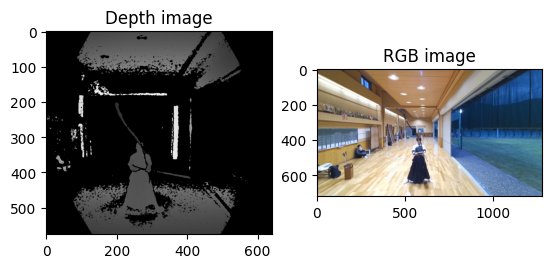

In [3]:
import cv2
rgb_image = iio.imread(r"C:\Users\b25.jun\Desktop\experiment_data\kimura\cap1\result_color\dev_0\color_0.jpg")
# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

In [2]:
R = np.array([[0.999983, 0.00587709,0.000154238],
               [-0.00586679, 0.995844, 0.090883],
               [0.000380531, -0.0908823,0.995862]], dtype=np.float32)

T = np.array([[-31.9808 / 1000.0],
                  [-2.14291 / 1000.0],
                  [4.06966  / 1000.0]], dtype=np.float32)

# RGB camera parameters:
FX_RGB = 610.737
FY_RGB = 610.621
CX_RGB = 639.815
CY_RGB = 363.492

# Depth camera parameters:
FX_DEPTH = 503.272
FY_DEPTH = 503.428
CX_DEPTH = 311.493 
CY_DEPTH = 341.854 

# Depth distortion coefficients [k1, k2, p1, p2, k3, k4, k5, k6]
depth_distortion = np.array([4.73664, 3.17892, 0.160328, 5.0622, 4.75137, 0.860637, -6.82809e-05, 2.82945e-05])

# Color distortion coefficients [k1, k2, p1, p2, k3, k4, k5, k6]
color_distortion = np.array([0.542059, -2.55717, 1.41391, 0.42556, -2.39546, 1.35091, 0.000694958, -0.000417294])


In [222]:
from datetime import datetime

# compute point cloud:
# get depth resolution:
start = datetime.now()
height, width = depth_image.shape
# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)
# Compute constants:
xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH
# transform depth image to vector of z:
length = height * width
z = depth_image.reshape(height * width)
# compute point cloud
pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))
#print non-empty points
pcd = pcd[~np.all(pcd == 0, axis=1)]  # remove points with all coordinates zero
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
end = datetime.now()
print(f"Point cloud computed in {end - start:}")


Point cloud computed in 0:00:00.024447


In [223]:
# Visualize point cloud:
o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization", width=800, height=600)

In [43]:
import numpy as np

# 1) get shapes
h_d, w_d = depth_image.shape
h_rgb, w_rgb, _ = rgb_image.shape

# 2) build depth‐cloud in depth‐cam coords
jj = np.tile(np.arange(w_d), h_d)
ii = np.repeat(np.arange(h_d), w_d)
z = depth_image.ravel().astype(np.float32) / 1000
x = (jj - CX_DEPTH) * z / FX_DEPTH
y = (ii - CY_DEPTH) * z / FY_DEPTH
pcd = np.vstack((x, y, z)).T  # (N,3)

# 3) transform to RGB camera coords
cam_rgb = (R @ pcd.T + T).T # (N,3)

# 4) project into RGB image
u = (cam_rgb[:,0] * FX_RGB) / cam_rgb[:,2] + CX_RGB
v = (cam_rgb[:,1] * FY_RGB) / cam_rgb[:,2] + CY_RGB

# 5) round, clip to RGB bounds
u = np.round(u).astype(int).clip(0, w_rgb - 1)
v = np.round(v).astype(int).clip(0, h_rgb - 1)

# 6) fetch colors (normalize to [0,1])
colors = rgb_image[v, u].astype(np.float32) / 255.0  # (N,3)


In [42]:
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd_o3d])

## Plot 3D Gaussians

In [49]:
# calculate covariance of points
def calculate_covariance(pcd):
    '''Given a point xyz, calculate the covariance matrix at that point.'''
    # Calculate variances for all points
    z = pcd[:, 2]  # Extract z-coordinates
    var_x = 3.5e-03 * z / (FX_DEPTH * 3.5e-03) 
    var_y = 3.5e-03 * z / (FY_DEPTH * 3.5e-03) 
    var_z = np.square(0.0007 * z - 0.0002) 

    # Get the number of points
    num_points = pcd.shape[0]

    # Create an empty array to store the covariance matrices
    # It will have shape (N, 3, 3)
    cov_matrices = np.zeros((num_points, 3, 3))

    # Fill the diagonal elements of each covariance matrix
    # This is also done efficiently using advanced indexing/broadcasting

    # Assign var_x to the (0,0) position for all matrices
    cov_matrices[:, 0, 0] = var_x * 0.01
    # Assign var_y to the (1,1) position for all matrices
    cov_matrices[:, 1, 1] = var_y * 0.01
    # Assign var_z to the (2,2) position for all matrices
    cov_matrices[:, 2, 2] = var_z * 0.01

    return cov_matrices

### Visualization

In [227]:
import numpy as np
import plotly.graph_objects as go

def plot_gaussians_interactive(means, covariances, subsample_factor=1,
                                     ellipsoid_scale=1.0, title="Collection of 3D Gaussians"):
    """
    Plots a collection of 3D Gaussians interactively using ellipsoidal glyphs.

    Args:
        means (list or np.ndarray): A list or array of mean vectors, shape (N, 3).
        covariances (list or np.ndarray): A list or array of covariance matrices, shape (N, 3, 3).
        subsample_factor (int): Factor to downsample the number of Gaussians to plot.
                                1 means plot all, 10 means plot every 10th. Defaults to 1.
        ellipsoid_scale (float): A scaling factor to control the size of the ellipsoids. Defaults to 1.0.
        title (str): The title for the plot.
    """
    if len(means) != len(covariances):
        raise ValueError("The number of means and covariance matrices must be the same.")

    # Subsample the data for performance if needed
    if subsample_factor > 1:
        means = means[::subsample_factor]
        covariances = covariances[::subsample_factor]

    # Plot the means as a scatter plot
    mean_points = go.Scatter3d(
        x=means[:, 0], y=means[:, 1], z=means[:, 2],
        mode='markers',
        marker=dict(size=3, color='rgba(0, 0, 0, 0.4)'),
        name='Means',
        hovertext=[f'Mean: {np.round(m, 2)}' for m in means]
    )

    fig = go.Figure(data=[mean_points])
    
    # Generate and add ellipsoid glyphs for each covariance
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        # Get eigenvectors (directions) and eigenvalues (squared variance)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # Eigenvalues are variance, so sqrt gives std deviation
        # Scale determines how many std deviations the ellipsoid represents
        radii = np.sqrt(eigenvalues) * ellipsoid_scale
        
        # Generate points on a unit sphere
        u = np.linspace(0, 2 * np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones_like(u), np.cos(v))

        # Scale, rotate, and translate the sphere to create the ellipsoid
        ellipsoid_points = np.stack([x_sphere, y_sphere, z_sphere], axis=-1)
        scaled_rotated_points = ellipsoid_points @ np.diag(radii) @ eigenvectors.T
        translated_points = scaled_rotated_points + mean

        x_ell, y_ell, z_ell = translated_points.T
        
        # Add the ellipsoid surface to the plot
        fig.add_trace(go.Surface(
            x=x_ell, y=y_ell, z=z_ell,
            opacity=0.1,
            showscale=False,
            colorscale=[[0, 'blue'], [1, 'blue']], # Single color
            name=f'Gaussian {i}',
            hoverinfo='none' # Hide hover for the surface to avoid clutter
        ))

    # Update layout
    fig.update_layout(
        title_text=title,
        scene=dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis',
            aspectmode='data' # Important for seeing the true shape
        ),
        showlegend=False,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

In [228]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians_matplotlib(means, covariances, subsample_factor=1,
                                     ellipsoid_scale=1.0, title="Collection of 3D Gaussians (Matplotlib)"):
    """
    Plots a collection of 3D Gaussians using Matplotlib.

    For interactivity (rotate, zoom), run this in a Jupyter Notebook
    with the magic command `%matplotlib widget` in a cell beforehand.

    Args:
        means (list or np.ndarray): A list or array of mean vectors, shape (N, 3).
        covariances (list or np.ndarray): A list or array of covariance matrices, shape (N, 3, 3).
        subsample_factor (int): Factor to downsample the number of Gaussians. Defaults to 1.
        ellipsoid_scale (float): Scaling factor for the ellipsoid size (in std deviations). Defaults to 1.0.
        title (str): The title for the plot.
    """
    if len(means) != len(covariances):
        raise ValueError("The number of means and covariance matrices must be the same.")

    # --- Setup the 3D Plot ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Subsample the data for performance if needed
    if subsample_factor > 1:
        means_sub = means[::subsample_factor]
        covariances_sub = covariances[::subsample_factor]
    else:
        means_sub = means
        covariances_sub = covariances

    # --- Plot the means as a scatter plot ---
    ax.scatter(means_sub[:, 0], means_sub[:, 1], means_sub[:, 2],
               c='black', s=5, alpha=0.5, label='Means')

    # --- Generate and add ellipsoid glyphs ---
    for mean, cov in zip(means_sub, covariances_sub):
        # Get eigenvectors (directions) and eigenvalues (squared variance)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # Radii are scaled standard deviations
        radii = np.sqrt(eigenvalues) * ellipsoid_scale
        
        # Generate points on a unit sphere
        u = np.linspace(0, 2 * np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones_like(u), np.cos(v))

        # Scale, rotate, and translate the sphere
        ellipsoid_points = np.stack([x_sphere, y_sphere, z_sphere], axis=-1)
        scaled_rotated_points = ellipsoid_points @ np.diag(radii) @ eigenvectors.T
        translated_points = scaled_rotated_points + mean
        
        x_ell, y_ell, z_ell = translated_points.T
        
        # Add the ellipsoid surface to the plot
        ax.plot_surface(x_ell, y_ell, z_ell,
                        rstride=4, cstride=4,  # Downsample the surface grid
                        color='blue',
                        alpha=0.1) # Use low alpha for transparency

    # --- Final Plot Adjustments ---
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title(title)

    # Set aspect ratio to be equal, requires some manual limit setting
    # This is important for not distorting the shape of the ellipsoids
    all_points = np.vstack(means_sub)
    x_min, y_min, z_min = all_points.min(axis=0)
    x_max, y_max, z_max = all_points.max(axis=0)
    
    max_range = np.array([x_max-x_min, y_max-y_min, z_max-z_min]).max() / 2.0
    
    mid_x = (x_max+x_min) * 0.5
    mid_y = (y_max+y_min) * 0.5
    mid_z = (z_max+z_min) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.view_init(elev=270, azim=270)

    plt.show()

### Calculate 3D Gaussians

In [45]:
def get_color_from_pcd(pcd):
    # 3) transform to RGB camera coords
    cam_rgb = (R @ pcd.T + T).T # (N,3)

    # 4) project into RGB image
    u = (cam_rgb[:,0] * FX_RGB) / cam_rgb[:,2] + CX_RGB 
    v = (cam_rgb[:,1] * FY_RGB) / cam_rgb[:,2] + CY_RGB 

    # 5) round, clip to RGB bounds
    u = np.round(u).astype(int).clip(0, w_rgb - 1)
    v = np.round(v).astype(int).clip(0, h_rgb - 1)

    # 6) fetch colors (normalize to [0,1])
    colors = rgb_image[v, u].astype(np.float32) / 255.0  # (N,3)

    return colors

In [50]:
# compute per‐point covariance
depths = pcd[:, 2]
valid_idx = np.nonzero(depths)[0]
idx = valid_idx[np.argsort(depths[valid_idx])]
# filter points and covariances
pcd_filtered = pcd[idx]
cov_matrices_filtered = calculate_covariance(pcd_filtered)
colors = get_color_from_pcd(pcd_filtered)
print(f"Filtered to {len(pcd_filtered)} points based on depth.")

Filtered to 104717 points based on depth.


In [51]:
# print covariance size near the camera
print(f"Covariance matrix size near the camera:\n {cov_matrices_filtered[0]}")

# print covariance size far from the camera
print(f"Covariance matrix size far from the camera:\n {cov_matrices_filtered[-1]}")

Covariance matrix size near the camera:
 [[1.40281989e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.40238519e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.65536278e-10]]
Covariance matrix size far from the camera:
 [[2.24232619e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.24163134e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.92822986e-07]]


### Create ply file

In [52]:
import numpy as np
from plyfile import PlyData, PlyElement

def create_gaussian_ply(centers, covariances, colors, output_path="gaussian_splats.ply"):
    """
    Create a PLY file compatible with the provided load_ply function.
    
    Args:
        centers: Point positions (N, 3)
        covariances: Covariance matrices (N, 3, 3)
        output_path: Output PLY file path
    """
    num_points = centers.shape[0]
    
    # Convert covariance to scale and rotation
    scales = np.zeros((num_points, 3))
    rotations = np.zeros((num_points, 4))  # quaternions
    
    for i in range(num_points):
        cov = covariances[i]
        # print(f"Covariance matrix for point {i}:\n{cov}")
        
        # Eigendecomposition
        _, eigenvecs = np.linalg.eigh(cov)
        eigenvals = np.array(cov.diagonal())
        
        # Ensure positive eigenvalues
        eigenvals = np.maximum(eigenvals, 1e-6)
        # print(f"Eigenvalues for point {i}: {eigenvals}")
        
        # Scale is square root of eigenvalues
        scales[i] = np.sqrt(eigenvals)

        # Convert rotation matrix to quaternion using Shepperd's method
        R = eigenvecs
        # print(f"Rotation matrix for point {i}:\n{R}")
        
        # Ensure proper rotation matrix (determinant = 1)
        if np.linalg.det(R) < 0:
            R[:, 0] *= -1
            
        trace = np.trace(R)
        
        if trace > 0:
            s = np.sqrt(trace + 1.0) * 2  # s = 4 * qw
            qw = 0.25 * s
            qx = (R[2, 1] - R[1, 2]) / s
            qy = (R[0, 2] - R[2, 0]) / s
            qz = (R[1, 0] - R[0, 1]) / s
        elif R[0, 0] > R[1, 1] and R[0, 0] > R[2, 2]:
            s = np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2]) * 2  # s = 4 * qx
            qw = (R[2, 1] - R[1, 2]) / s
            qx = 0.25 * s
            qy = (R[0, 1] + R[1, 0]) / s
            qz = (R[0, 2] + R[2, 0]) / s
        elif R[1, 1] > R[2, 2]:
            s = np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2]) * 2  # s = 4 * qy
            qw = (R[0, 2] - R[2, 0]) / s
            qx = (R[0, 1] + R[1, 0]) / s
            qy = 0.25 * s
            qz = (R[1, 2] + R[2, 1]) / s
        else:
            s = np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1]) * 2  # s = 4 * qz
            qw = (R[1, 0] - R[0, 1]) / s
            qx = (R[0, 2] + R[2, 0]) / s
            qy = (R[1, 2] + R[2, 1]) / s
            qz = 0.25 * s
            
        rotations[i] = [qx, qy, qz, qw]
    
    # Create constant opacity (set to 1.0, but in logit space for the function)
    # logit(1) is undefined, so we use a high value that maps to ~1 after sigmoid
    opacities = np.full((num_points,), 5)  # sigmoid(5) ≈ 0.993
    
    # SH DC coefficients (0th order) - these represent the base color
    # use passed-in colors
    f_dc_0 = colors[:, 0].astype(np.float32)  # R
    f_dc_1 = colors[:, 1].astype(np.float32)  # G
    f_dc_2 = colors[:, 2].astype(np.float32)  # B
    
    # Create vertex data
    vertex_data = []
    for i in range(num_points):
        vertex_data.append((
            centers[i, 0],      # x
            centers[i, 1],      # y
            centers[i, 2],      # z
            f_dc_0[i],          # f_dc_0 (SH coeff for R)
            f_dc_1[i],          # f_dc_1 (SH coeff for G)
            f_dc_2[i],          # f_dc_2 (SH coeff for B)
            opacities[i],       # opacity
            scales[i, 0],       # scale_0
            scales[i, 1],       # scale_1
            scales[i, 2],       # scale_2
            rotations[i, 0],    # rot_0 (qx)
            rotations[i, 1],    # rot_1 (qy)
            rotations[i, 2],    # rot_2 (qz)
            rotations[i, 3],    # rot_3 (qw)
        ))
    
    # Define the vertex element structure
    vertex_element = PlyElement.describe(
        np.array(vertex_data, dtype=[
            ('x', 'f4'),
            ('y', 'f4'),
            ('z', 'f4'),
            ('f_dc_0', 'f4'),
            ('f_dc_1', 'f4'),
            ('f_dc_2', 'f4'),
            ('opacity', 'f4'),
            ('scale_0', 'f4'),
            ('scale_1', 'f4'),
            ('scale_2', 'f4'),
            ('rot_0', 'f4'),
            ('rot_1', 'f4'),
            ('rot_2', 'f4'),
            ('rot_3', 'f4'),
        ]),
        'vertex'
    )
    
    # Write PLY file
    PlyData([vertex_element], text=True).write(output_path)
    print(f"✅ Created Gaussian Splat PLY file: {output_path}")
    print(f"   Number of Gaussians: {num_points}")
    print(f"   Format: Compatible with 3D Gaussian Splatting")
    print(f"   Features: Grayscale colors, constant opacity, proper scales/rotations")

# Generate the PLY file
create_gaussian_ply(
    centers=pcd_filtered,
    covariances=cov_matrices_filtered,
    colors=colors,
    output_path="gaussian_splats_dev0.ply"
)

✅ Created Gaussian Splat PLY file: gaussian_splats_dev0.ply
   Number of Gaussians: 104717
   Format: Compatible with 3D Gaussian Splatting
   Features: Grayscale colors, constant opacity, proper scales/rotations
